<a href="https://colab.research.google.com/github/earandir/DataAnalysis/blob/main/Modulo04/CheckPoint/Proyecto_CheckPoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Módulo 04 - Proyecto CheckPoint

## Análisis de atención y soporte en Mesa de Ayuda

## 1. Objetivos:
* Obtener las órdenes de trabajo desde una base de datos
* Obtener la información de los agentes encargados
* Unir ambas tablas para obtener inforamción completa
* Analizar y transformar a Dataframes
* Verificar que los datos sean del tipo correcto
* Transformar las fechas en diferentes formatos para análisis
* Análisis exploratorio de los datos
* Gráficas de resultados

## 2. Desarrollo:

#### Importación de bibliotecas utilizadas

In [ ]:
import pandas as pd
import datetime


### a) Obtener órdenes de trabajo:

Para iniciar el proyecto, es necesario leer la información de la órdenes. Esta inofrmación se encuentra en dos archivos:


*   Es necesario leer el encabezado de las solicitudes con el archivo: solicitudes.csv
*   El detalle del trabajo realizado en cada una de las solicitudes se encuentra en el archivo: solicitudesdetalle.csv

Después se necesario unir ambos registros para tener la información completa.



In [ ]:
solicitudes = pd.read_csv('solicitudes.csv', index_col=0)

solicitudes_detalle = pd.read_csv('solicitudes_detalle.csv', index_col=0)

In [ ]:
pd.merge(solicitudes, solicitudes_detalle, left_on='idSolicitud', right_index=True)

,idAgente_x,idUsuario,FechaCreacion_x,FechaResolucion,Categoria,SubCategoria,idModo,idModulo,ValorEncuesta,idSolicitud,idTipodeTrabajo,idAgente_y,FechaCreacion_y,FechaInicio,FechaFin,TiempoTranscurrido,TarifaAgente,CostoTrabajo
idSolicitud,,,,,,,,,,,,,,,,,,
15762,694,616,2018-09-19 05:23:43,NaN,Soporte Externo,Error,10,66,0,23941,352,64,2021-04-05 04:32:01,2021-03-24 22:38:00,2021-03-25 00:19:00,6060,262,22


Además de las solicitudes, faltaría agregar la información de los usuarios, los agentes, módulos y tipos de trabajo.

Pero en la base de datos encontramos un procedimiento que nos hace la unión de toda la información necesaria, así que vamos a usar esta vista para simplificar el proceso y no tener que unir todas las tablas.

In [ ]:
registros = pd.read_csv('registrosmesaservicio.csv', index_col=0)

registros.head(3)

,Solicitante,Modo,FechaCreacionSolicitud,Modulo,Agente,Categoria,SubCategoria,ValorEncuesta,AgenteTrabajo,Trabajo,FechaCreacionTrabajo,FechaInicio,FechaFin,TiempoTranscurrido,TarifaAgente,CostoTrabajo
idSolicitud,,,,,,,,,,,,,,,,
17804,Jaime,Web,2019-11-30 04:48:30,Zinc e-commerce,Sonia,Soporte Externo,Error,0,Sonia,Not Assigned,2020-01-02 17:50:30,2020-01-02 09:33:00,2020-01-02 09:40:00,420,242,21
17908,KENIA,Llamada,2020-01-03 01:17:50,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:23:02,2020-01-02 13:00:00,2020-01-02 13:24:00,1440,242,21
17909,David,Llamada,2020-01-03 01:50:12,Nomina,Sonia,Soporte Externo,Consulta,0,Sonia,Not Assigned,2020-01-02 19:53:51,2020-01-02 13:34:00,2020-01-02 13:54:00,1200,242,21


### b) Revisión de datos y conversión de tipos:
Al revisar los datos del DataFrame, encontramos las fechas registradas como tipo "Objeto", por lo que hacemos la conversión al tipo "datetime" para poder realizar operaciones con las fechas.

In [ ]:
registros.dtypes

Solicitante               object
Modo                      object
FechaCreacionSolicitud    object
Modulo                    object
Agente                    object
Categoria                 object
SubCategoria              object
ValorEncuesta              int64
AgenteTrabajo             object
Trabajo                   object
FechaCreacionTrabajo      object
FechaInicio               object
FechaFin                  object
TiempoTranscurrido         int64
TarifaAgente               int64
CostoTrabajo               int64
dtype: object

In [ ]:
dates_dict = {'FechaCreacionSolicitud':'datetime64[ns]' \
              , 'FechaCreacionTrabajo': 'datetime64[ns]' \
              , 'FechaInicio': 'datetime64[ns]' \
              , 'FechaFin': 'datetime64[ns]'}
registros = registros.astype(dates_dict)     

registros.dtypes

Solicitante                       object
Modo                              object
FechaCreacionSolicitud    datetime64[ns]
Modulo                            object
Agente                            object
Categoria                         object
SubCategoria                      object
ValorEncuesta                      int64
AgenteTrabajo                     object
Trabajo                           object
FechaCreacionTrabajo      datetime64[ns]
FechaInicio               datetime64[ns]
FechaFin                  datetime64[ns]
TiempoTranscurrido                 int64
TarifaAgente                       int64
CostoTrabajo                       int64
dtype: object

### c) Análisis Exploratorio de datos:

Una vez que contamos con la información completa, es momento de empezar a resolver dudas en relación a estos datos.

####1) ¿De qué módulos piden ayuda?

Para responder esta pregunta, es necesario agrupar por módulo todas las solicitudes y agregar la columna con el conteo de registros, dejando los 10 módulos que  más tienen registros.

In [ ]:
top_modulos = registros.groupby('Modulo') \
  .agg(conteo=('Modulo', 'size')) \
  .reset_index()

top_modulos = top_modulos.sort_values('conteo', ascending=False)

top_modulos[:10]

,Modulo,conteo
14,General,4105
17,Nomina,1576
25,Ventas,811
20,Punto de venta,707
11,Cuentas por Cobrar,430
10,Contabilidad,399
26,Zinc e-commerce,275
15,Inventarios,243
19,PDA o Candados,227
21,Reporteador,216


####2) ¿De qué forma contactan al equipo de soporte?

Esta pregunta se puede responder de una manera muy similar a la pregunta anterior, utilizando el campo del modo de contacto.

In [ ]:
modos = registros.groupby('Modo') \
  .agg(conteo=('Modo', 'size')) \
  .reset_index()

modos = modos.sort_values('conteo', ascending=False)

modos[:5]

,Modo,conteo
3,Llamada,5232
4,Web,2044
2,En sitio,1580
1,E-Mail,1472
0,Chat,88


####3) ¿Quién es la persona a la que más tiempo se le ha invertido?

En este caso, es necesario analizar los registros por usuario y sumar el tiempo invertido en cada una de las tareas que se hayan realizdo en sus casos de soporte técnico.

In [ ]:
soporte_externo = registros.loc[registros['Categoria'] == 'Soporte Externo']

tiempo_usuario = soporte_externo.groupby('Solicitante') \
  .agg(tiempo_invertido=('TiempoTranscurrido', 'sum')) \
  .reset_index()

tiempo_usuario = tiempo_usuario.sort_values('tiempo_invertido', ascending=False)

tiempo_usuario['tiempo_invertido'] = tiempo_usuario['tiempo_invertido'] // 86400

tiempo_usuario[:5]

,Solicitante,tiempo_invertido
161,Rosa,11
91,Jaime,7
117,MARCO,6
155,Ricardo,5
167,Santiago,3


####4) ¿Cuantos casos se han recibido en cada mes del año?

Para responder esta pregunta, se requiere transformar el campo de la fecha para obtener el mes que le corresponde para poder sumar los casos por cada uno de los meses.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


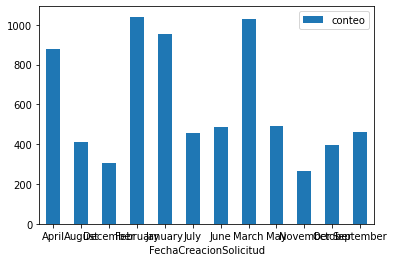

In [ ]:
soporte_externo = registros.loc[registros['Categoria'] == 'Soporte Externo']
soporte_externo['FechaCreacionSolicitud'] = soporte_externo['FechaCreacionSolicitud'].apply(lambda x: x.strftime('%B'))

soporte_externo = soporte_externo.groupby('FechaCreacionSolicitud') \
  .agg(conteo=('FechaCreacionSolicitud', 'size')) \
  .reset_index()

soporte_externo.plot.bar(x='FechaCreacionSolicitud', y='conteo', rot=0)

filtrar por mes y por año para gráfica de serie de tiempo

anaálisis exploratorio de datos
tiempo invertido
tikets recibidos



revisar carga de trabajo por agente y promedios de atención por módulo

recomendación de mejor agente para un módulo